# 회귀 자동차 연비구하기

산점도 행렬을 그리기위해 seaborn을 설치합니다.

In [1]:
!pip install -q seaborn

pathlib은 파일위치찾기, 파일 입출력등을 하기위한 라이브러리입니다.

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0-dev20190804


## 데이터 다운로드

회귀를 위한 데이터셋은 Auto MPG 데이터을 사용합니다. UCI 머신 러닝 저장소에서 다운가능합니다.

Auto MPG데이터셋의 속성정보는 이렇습니다.

1. mpg : 연속 
2. 실린더 : 다중 값 이산 
3. 변위 : 연속 
4. 마력 : 연속 
5. 무게 : 연속 
6. 가속 : 연속 
7. 모델 연도 : 다중 값 이산 
8. 원산지 : 다중 값 이산 
9. 차량 이름 : 문자열 (각 인스턴스마다 고유함)


데이터셋을 다운받습니다.

In [44]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path #

'C:\\Users\\Jiyeon\\.keras\\datasets\\auto-mpg.data'

In [45]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [46]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [47]:
dataset = dataset.dropna()

one-hot encoding은 데이터를 중복없이 표현하기위해 사용됩니다.

예를 들어 

사과,오렌지,바나나를 표현할 때

사과-[1,0,0]

오렌지-[0,1,0]

바나나-[0,0,1]

벡터로 데이터를 나타냅니다.

In [48]:
origin = dataset.pop('Origin')

In [49]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 데이터셋을 훈련 세트와 테스트 세트로 분할하기

In [50]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 데이터 조사하기

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

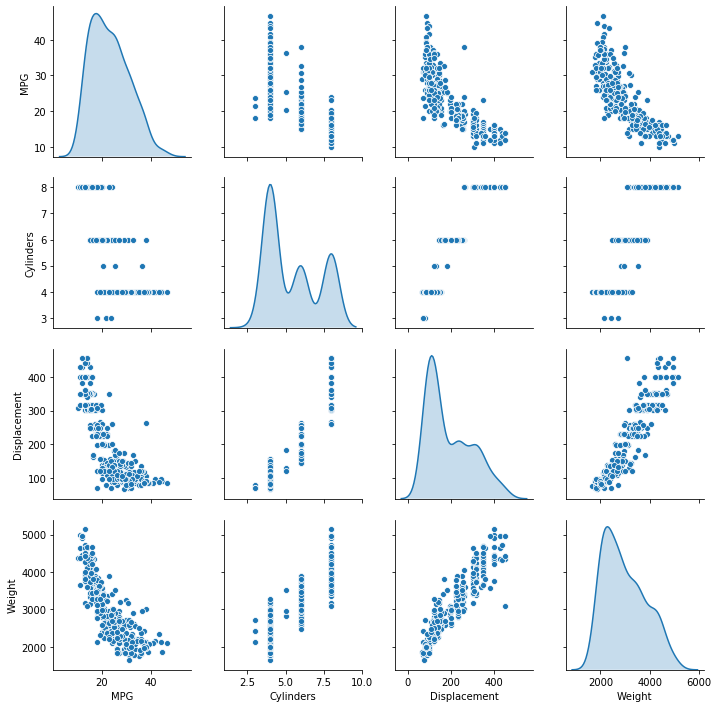

In [51]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
#kde는 커널 밀도 추정을 뜻합니다.

전반적인 통계를 보도록 하겠습니다.

In [52]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 특성과 레이블 분리하기

In [53]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 데이터 정규화

특성의 스케일과 범위가 다르면 정규화(normalization)를 해야 훈련이 편해집니다.

정규화는 (x - x_min) / (x_max - x_min) 으로 모든 데이터를 0~1로 맞추어주는 것이고 

표준화는 (x - x_mean) / x_std 로 모든 값에 평균을 빼고 표준편차를 나누어주어 데이터의 평균을 0으로 맞추는 작업입니다. 

In [54]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

-AdaGrad(Adaptive Gradient)

AdaGrad가 학습률 감소를 도입한 기본적인 매개변수 최적화 알고리즘입니다. 

간단하게, 가중치 매개변수 전체의 학습률을 일괄적으로 낮추는 것입니다. 

AdaGrad는 이를 구현하여, 가중치 매개변수의 각각 원소에 맞는 맞춤형 학습률 값을 만들어 줍니다. 

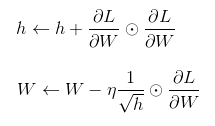

-RMSProp

AdaGrad의 위와 같은 문제를 해결하기 위하여 만들어진 알고리즘이 RMSProp입니다. 

RMSProp의 아이디어는 먼 과거의 기울기를 서서히 잊고 최근의 새로운 기울기 정보를 학습률 갱신에 크게 반영하자는 것입니다. 



그리고 이 과정에서, 지수이동평균(EMA)을 사용합니다.

a가 0에 가까울 수록 과거의 값만 반영하고, 1에 가까울수록 최신의 값만 반영하게 됩니다. 

보통 0.8이나 0.9에 가까운 값을 사용하는 것 같습니다.

값이 업데이트될수록 과거의 값들은 (1-a)라는 계수의 영향을 계속 누적해서 받게 되어 영향이 점점 줄어들게 됩니다. 

하지만 영향이 아예 사라지지는 않습니다.

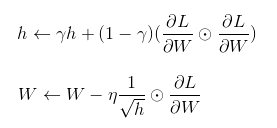

학습률의 갱신에 지수이동평균을 적용하고 있습니다. 

지수이동평균의 성질에 의해 과거의 값들은 서서히 잊혀지고, 새로 갱신된 기울기의 제곱 값이 상대적으로 크게 반영되고 있는 것을 볼 수 있습니다. 

RMSProp는 이 방법을 사용하여 의 값이 무한정으로 커지는 문제를 해결했습니다.


http://shuuki4.github.io/deep%20learning/2016/05/20/Gradient-Descent-Algorithm-Overview.html

모델을 만드는 방법

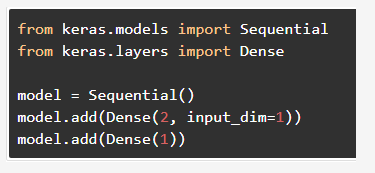

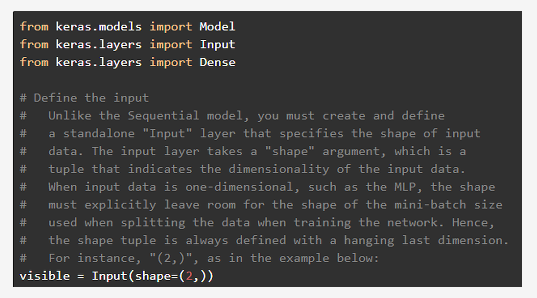

In [55]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[9]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
      
    #tf.layers.dense(input, bias_initializer, units)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [56]:
model = build_model()

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [58]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.1916969 ],
       [-0.05273031],
       [-0.52169925],
       [-0.003957  ],
       [ 0.49138746],
       [-0.0246228 ],
       [ 0.5161178 ],
       [ 0.4436175 ],
       [-0.0911253 ],
       [ 0.43447518]], dtype=float32)

In [59]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [60]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.650015,1.024200,2.650015,8.165938,2.170423,8.165938,995
996,2.770702,1.037643,2.770702,7.873572,2.126773,7.873572,996
997,2.468893,0.987052,2.468893,8.695846,2.182263,8.695846,997
998,2.571318,1.116755,2.571318,7.800414,2.119457,7.800414,998
999,2.453808,1.000268,2.453808,7.955504,2.211168,7.955504,999


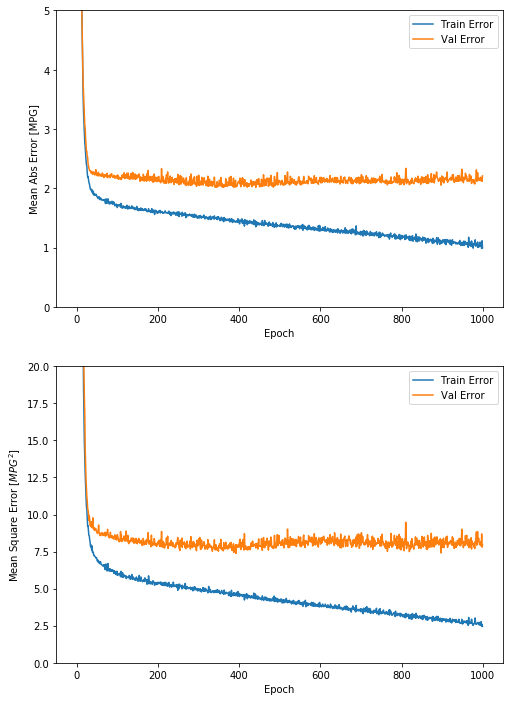

In [61]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

model.fit 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보겠습니다.

에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하겠습니다. 

지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.


......................................................................

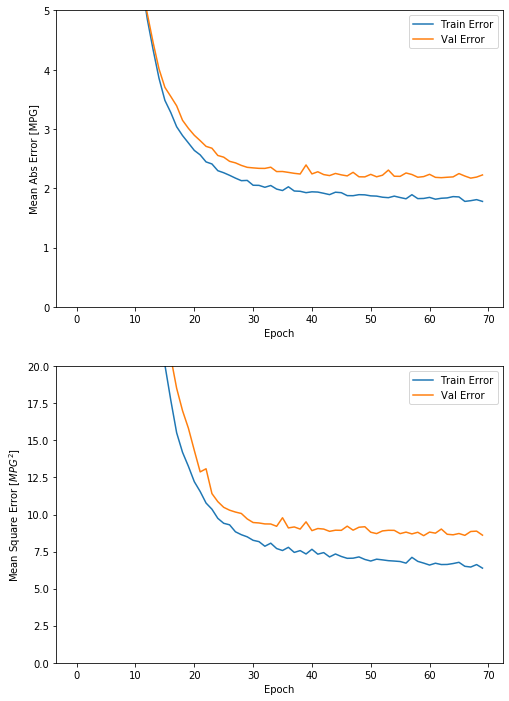

In [62]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [70]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


In [71]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
55     27.0
212    16.5
234    24.5
103    11.0
289    16.9
355    33.7
276    21.6
75     14.0
114    26.0
305    28.4
166    13.0
134    16.0
60     20.0
386    25.0
309    41.5
38     14.0
340    25.8
255    25.1
169    20.0
66     17.0
       ... 
326    43.4
124    11.0
224    15.0
63     14.0
298    23.0
132    25.0
189    15.5
23     26.0
44     13.0
0      18.0
203    29.5
335    35.0
99     18.0
385    38.0
180    25.0
258    20.6
95     12.0
366    17.6
96     13.0
347    37.0
171    24.0
70     13.0
307    26.8
49     23.0
209    19.0
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [63]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

테스트 세트의 평균 절대 오차:  1.87 MPG


In [73]:
normed_test_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,1.483887,1.865988,2.234620,1.018782,-2.530891,-1.604642,0.774676,-0.465148,-0.495225
25,1.483887,1.578444,2.890853,1.925289,-0.559020,-1.604642,0.774676,-0.465148,-0.495225
28,1.483887,1.041693,2.313368,2.063931,1.054328,-1.604642,0.774676,-0.465148,-0.495225
31,-0.869348,-0.789008,-0.259066,-0.903250,-0.559020,-1.332580,-1.286751,-0.465148,2.012852
33,0.307270,0.351586,-0.127819,-0.422150,-0.917542,-1.332580,0.774676,-0.465148,-0.495225
39,1.483887,1.961837,1.840880,1.746357,-1.455325,-1.332580,0.774676,-0.465148,-0.495225
40,1.483887,1.492180,1.263395,1.379015,-0.738281,-1.332580,0.774676,-0.465148,-0.495225
43,1.483887,1.961837,1.709634,2.080521,-1.276064,-1.332580,0.774676,-0.465148,-0.495225
48,0.307270,0.524113,-0.442811,0.176263,-0.379759,-1.332580,0.774676,-0.465148,-0.495225
54,-0.869348,-1.181986,-0.941548,-1.632011,0.875068,-1.332580,-1.286751,-0.465148,2.012852


In [72]:
test_labels

9      15.0
25     10.0
28      9.0
31     25.0
33     19.0
39     14.0
40     14.0
43     13.0
48     18.0
54     35.0
58     25.0
71     19.0
73     13.0
83     28.0
85     13.0
88     14.0
89     15.0
92     13.0
100    18.0
106    12.0
116    16.0
118    24.0
120    19.0
122    24.0
129    31.0
130    26.0
133    16.0
149    24.0
153    18.0
165    20.0
       ... 
264    18.1
267    27.5
269    30.9
275    17.0
279    29.5
287    16.5
290    15.5
292    18.5
293    31.9
294    34.1
316    19.1
323    27.9
325    44.3
337    32.4
339    26.6
341    23.5
342    30.0
343    39.1
349    34.1
351    34.4
353    33.0
359    28.1
363    22.4
364    26.6
367    28.0
369    34.0
375    36.0
382    34.0
384    32.0
396    28.0
Name: MPG, Length: 78, dtype: float64

## 예측

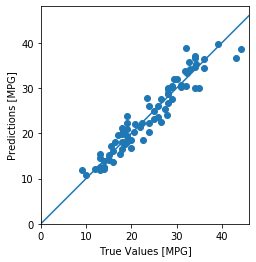

In [64]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

오차의 분포

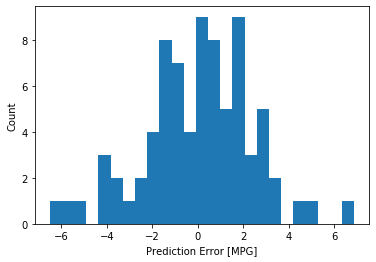

In [65]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")